### 1. Import Dependencies and Setup 📥

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2. Load Data 📚

In [4]:
data_dir = 'data/images'
classes = os.listdir(data_dir)
classes

['pneumonia', 'normal']

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 5856 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

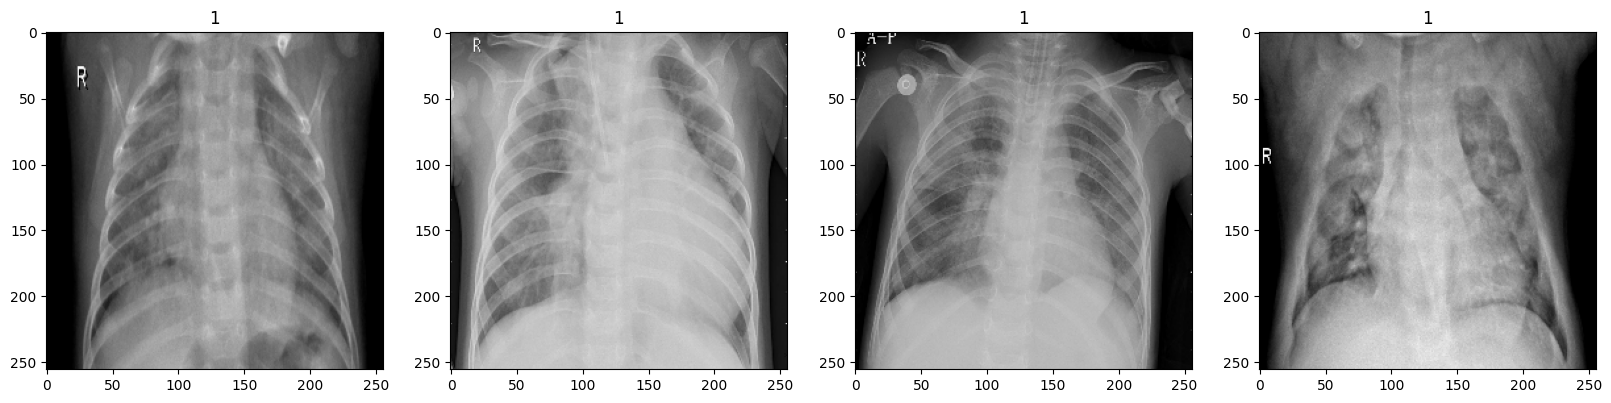

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
batch[0].min() ,batch[0].max()

(0.0, 255.0)

### 3. Data Preprocessing & Scaling 📝

In [9]:
scaled = batch[0] / 255.0
scaled.min(), scaled.max()

(0.0, 1.0)

In [10]:
data = data.map(lambda x, y: (x / 255.0, y))

In [12]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32))

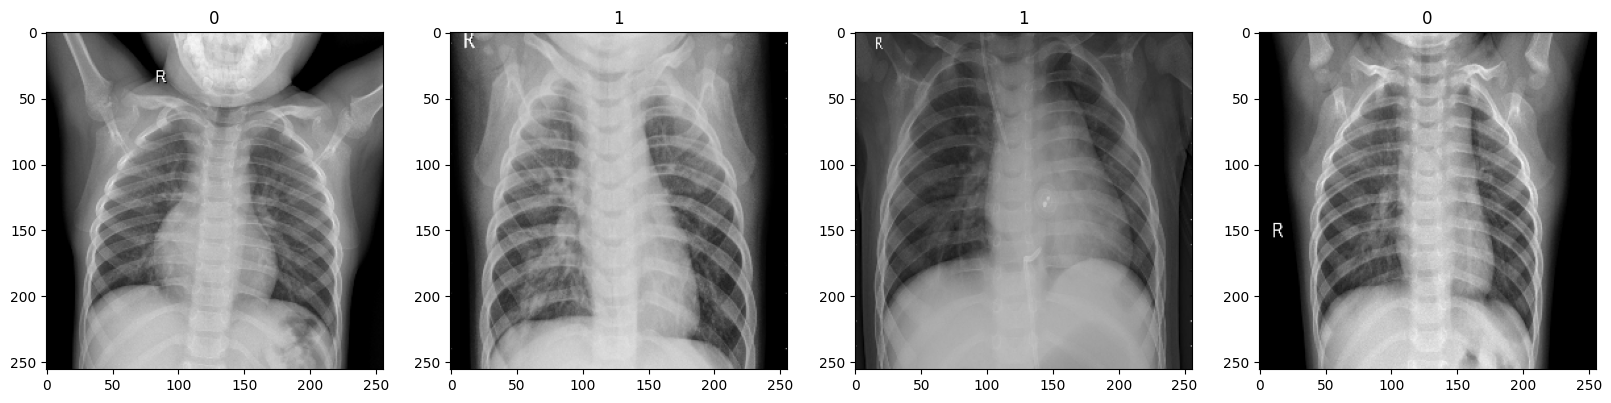

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 4. Splitting Data into Training, Valuating and Testing Sets 🗡️

In [17]:
data_length = len(data) # 183 * 32 = 5856

train_size = int(data_length * 0.7) # 128 * 32 = 4096
val_size = int(data_length * 0.2) # 36 * 32 = 1152
test_size = int(data_length * 0.1) # 18 * 32 = 576

train_size, val_size, test_size

(128, 36, 18)

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### 5. Model Building 🏗️

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

### 6. Model Training 🧠

In [26]:
logs_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [ ]:
history = model.fit(train, epochs=24, validation_data=val, callbacks=[tensorboard_callback])

### 7. Plot Performance 📈

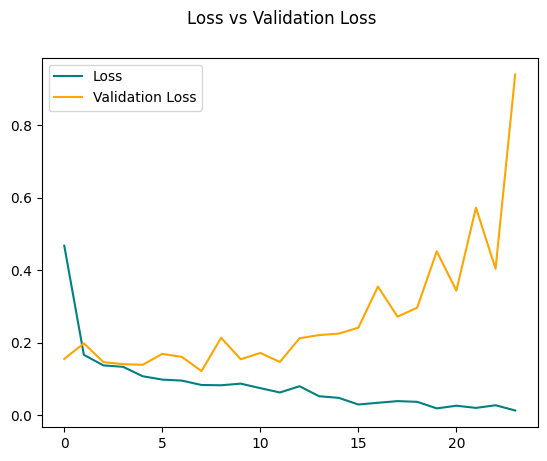

In [32]:
accuracy, val_accuracy = history.history['loss'], history.history['val_loss']

fig = plt.figure()
plt.plot(accuracy, color = 'teal', label='Loss')
plt.plot(val_accuracy, color = 'orange', label='Validation Loss')
fig.suptitle('Loss vs Validation Loss')
plt.legend(loc='upper left')
plt.show()

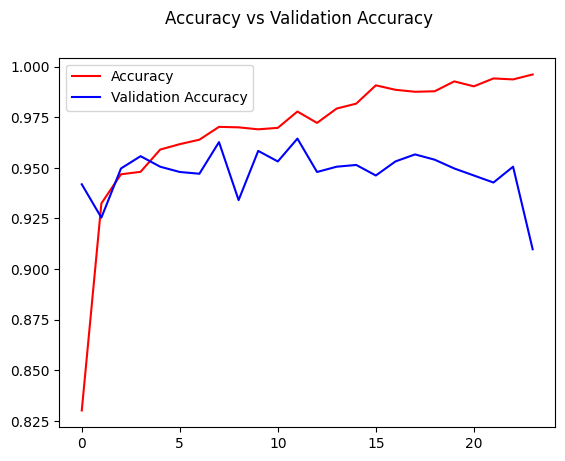

In [34]:
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig = plt.figure()
plt.plot(accuracy, color = 'red', label='Accuracy')
plt.plot(val_accuracy, color = 'blue', label='Validation Accuracy')
fig.suptitle('Accuracy vs Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

### 8. Model Evaluation 🧾

In [36]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

In [38]:
print('Precision: ', pre.result().numpy())
print('Recall: ', rec.result().numpy())
print('Accuracy: ', acc.result().numpy())

Precision:  0.986911
Recall:  0.882904
Accuracy:  0.9045139


### 9. Testing Model 🧪

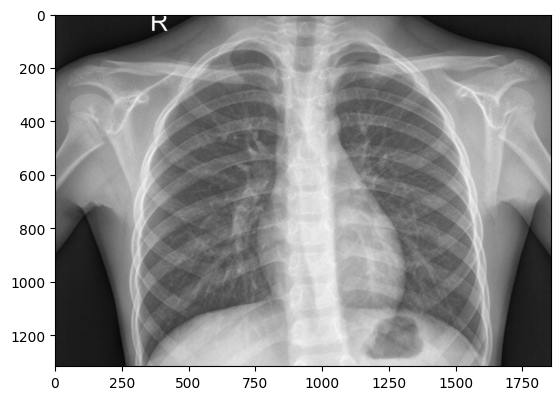

In [40]:
img = cv2.imread('data/images/normal/IM-0001-0001.jpeg')
plt.imshow(img)
plt.show()

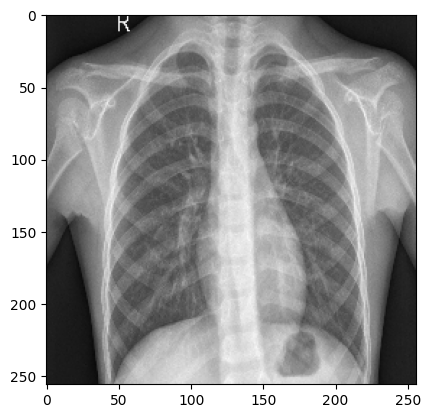

In [41]:
resized = cv2.resize(img, (256, 256))
plt.imshow(resized)
plt.show()

In [42]:
yhat = model.predict(np.array([resized / 255.0]))
yhat

1/1 [==============================] - 0s 288ms/step


array([[1.0950585e-17]], dtype=float32)

In [43]:
if yhat > 0.5:
    print('Pneumonia')
else:
    print('Normal')

Normal


In [47]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        print('Pneumonia')
    else:
        print('Normal')

predict('data/images/normal/IM-0001-0001.jpeg')
predict('data/images/pneumonia/person1_bacteria_1.jpeg')

Normal
Pneumonia


### 10. Save Model ⬇️

In [50]:
model.save('models/main_model.keras')

In [51]:
new_model = load_model('models/main_model.keras')

In [56]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = new_model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        return 'Pneumonia'
    return 'Normal'

predict('data/images/normal/IM-0001-0001.jpeg'), predict('data/images/pneumonia/person1_bacteria_1.jpeg')

('Normal', 'Pneumonia')